In [1]:
import pandas as pd, os
from utils.util import is_laptop
from datetime import date

In [2]:
folder_path = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/' if is_laptop() else 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/data/'
hourly_path = folder_path + 'Measured/combined_klst/' + max(os.listdir(folder_path + 'Measured/combined_klst/'), key = lambda f: os.path.getmtime(folder_path + 'Measured/combined_klst/' + f))
merged_path = folder_path + 'Combined/' + max((f for f in os.listdir(os.path.join(folder_path, 'Combined')) if os.path.isfile(os.path.join(folder_path, 'Combined', f))), key=lambda f: os.path.getmtime(os.path.join(folder_path, 'Combined', f)))

In [3]:
hourly_df = pd.read_feather(hourly_path)
merged_df = pd.read_feather(merged_path)

In [4]:
# Rounds to next hour so as to be able to directly compare with the vedur klst file
def next_hour(time):
    return time.ceil('h')

In [5]:
hourly_df.stod = pd.to_numeric(hourly_df.stod, errors = 'coerce')
hourly_df.timi = pd.to_datetime(hourly_df.timi, errors = 'coerce')
hourly_df.fx = pd.to_numeric(hourly_df.fx, errors = 'coerce')
hourly_df.fg = pd.to_numeric(hourly_df.fg, errors = 'coerce')
hourly_df.f = pd.to_numeric(hourly_df.f, errors = 'coerce')
#hourly_df = hourly_df[(hourly_df.fx < 65) & (hourly_df.fg < 75)]
 
merged_df['timi'] = merged_df.time.apply(next_hour)

In [22]:
merged_df.shape

(69467, 30)

In [7]:
hourly_df.shape

(46476897, 6)

In [6]:
combined_df = pd.merge(merged_df, hourly_df, on = ['stod', 'timi'], how = 'inner', suffixes=('_merged', '_hourly'))
combined_df = combined_df.dropna(subset=['fg_hourly'])

In [7]:
combined_df.shape

(67537, 34)

In [11]:
combined_df.shape

(68621, 34)

In [8]:
nails_df = combined_df[~(abs(combined_df.f_merged - combined_df.fx) <= 0.1)]

In [9]:
from matplotlib import pyplot as plt
import os, numpy as np, seaborn as sns, pandas as pd
from math import exp, log, log10

In [10]:
len(nails_df.stod.unique())

97

In [11]:
len(combined_df.stod.unique())

318

In [12]:
len(merged_df.stod.unique())

318

In [13]:
len(hourly_df.stod.unique())

351

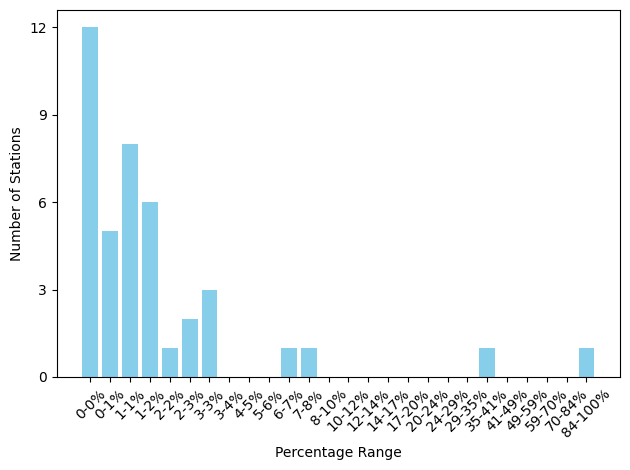

In [15]:
# Combine value counts from both DataFrames to ensure all values are present
combined_value_counts = pd.concat([nails_df.stod.value_counts(), combined_df.stod.value_counts()], axis=1, keys=['nails', 'combined']).fillna(0)

# Calculate the quotient of percentages
quotient = (combined_value_counts['nails'] / combined_value_counts['combined']).fillna(0)

# Automatically set ranges based on the quotient values
min_val = quotient.min()
max_val = quotient.max()
n = 40
range_width = (max_val - min_val) / n  # Divide into n ranges
ranges = np.logspace(-3, np.log10(max_val), num=n)
ranges = [(0, ranges[0])] + [(ranges[i], ranges[i+1]) for i in range(len(ranges)-1)]

# Calculate the quotient of percentages falling into each range
quotient_ranges = {}
for lower, upper in ranges:
    quotient_range = (combined_value_counts['nails'] / combined_value_counts['combined']).between(lower, upper).sum()
    quotient_ranges[f'{lower*100:.0f}-{upper*100:.0f}%'] = quotient_range

# Plot the graph
plt.bar(quotient_ranges.keys(), quotient_ranges.values(), color='skyblue')
plt.xlabel('Percentage Range')
plt.ylabel('Number of Stations')
plt.xticks(rotation=45)
plt.yticks(range(0, 14, 3))
plt.tight_layout()

plt.savefig('../visualization/outputs/png/error_count_30.png')

plt.show()

In [25]:
nailStripped_df = combined_df[abs(combined_df.f_merged - combined_df.fx) <= 0.1]
assert nailStripped_df.f_merged.max() < 65

In [29]:
df_toWrite = nailStripped_df[['X', 'Y', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15',
       'wd_250', 'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500',
       'stod', 'f_merged', 'fg_merged', 'd_merged', 'Ri_01', 'Ri_12', 'Ri_02', 'N_01', 'N_12', 'N_02']]

df_toWrite.columns

Index(['X', 'Y', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15', 'wd_250',
       'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500', 'stod',
       'f_merged', 'fg_merged', 'd_merged', 'Ri_01', 'Ri_12', 'Ri_02', 'N_01',
       'N_12', 'N_02'],
      dtype='object')

In [30]:
df_toWrite = df_toWrite.rename({'f_merged':'f', 'fg_merged':'fg', 'd_merged':'d'}, axis = 1)

df_toWrite.columns

Index(['X', 'Y', 'time', 'ws_15', 'ws_250', 'ws_500', 'wd_15', 'wd_250',
       'wd_500', 'p_15', 'p_250', 'p_500', 't_15', 't_250', 't_500', 'stod',
       'f', 'fg', 'd', 'Ri_01', 'Ri_12', 'Ri_02', 'N_01', 'N_12', 'N_02'],
      dtype='object')

In [31]:
outputpath = folder_path + f'NailStripped/merged_stripped_{date.today()}.feather'
df_toWrite.to_feather(outputpath)